# Zadatak

Na adresi https://www.foi.unizg.hr/hr/dokumenti nalazi se baza dokumenata Fakulteta organizacije i informatike. Većina dokumenata zadana je u PDF formatu, no neki od dokumenata su čitki (vektorski format) dok su drugi skenirani (rasterski format). Potrebno je:
1) Implementirati program koji će skinuti sve PDF dokumente na lokalno računalo (ili Google Colab / Drive direktorij)
2) Kreirati bazu podataka (SQLite) koja će sadržavati jednu tablicu "dokument". Tablica treba sadržavati šifru dokumenta (autonumber), naslov dokumenta, putanju datoteke (path i filename na lokalnom računalu), URL adresu s koje je dokument skinut, datum, te tekstualni sadržaj dokumenta.
3) Posebno za zadnje polje u tablici potrebno je svaki dokument učitati i ekstrahirati tekst (primjerice putem Python modula PDFMiner - https://github.com/pdfminer/pdfminer.six). Ukoliko je dokument skeniran potrebno je koristiti odgovarajući OCR modul za ekstrakciju teksta (npr. PyTesseract https://pypi.org/project/pytesseract/).
4) Omogućiti pristup skupu podataka putem REST API-ja koji omogućuje isključivo pretraživanje podataka putem:(a) pretraživanja ključnih riječi u tekstu (npr. boolean search), (b) pretraživanje ključnih riječi u naslovu (c) pregled prema datumu (npr. dokumenti od DATUM do DATUM), (d) izlistavanje svih dokumenata.

# Automatizirano prikupljanje i pretraga PDF dokumenata s Fakulteta organizacije i informatike

**GitHub repo:** https://github.com/dsabljic/PAP-FOI-docs

## Uvod

### Motivacija
U današnjem digitalnom dobu, sposobnost brze i učinkovite pretrage velike količine podataka postala je ključna komponenta u mnogim područjima, uključujući akademsku zajednicu i istraživačke institucije. Fakultet organizacije i informatike (FOI) predstavlja bogat izvor raznovrsnih akademskih materijala, posebice u obliku PDF dokumenata. Ovi dokumenti sadrže vrijedne informacije koje su ključne za studente, istraživače i djelatnike Fakulteta. Međutim, izazov leži u tome što su ti dokumenti raspršeni i nisu jednostavno pretraživi, što otežava njihovo korištenje i analizu.

### Cilj projekta
Cilj ovog projekta je razviti sustav koji automatizira proces prikupljanja PDF dokumenata s web stranice FOI-a, ekstrakciju i obradu njihovog sadržaja, te stvaranje pristupačne baze podataka koja omogućava jednostavno pretraživanje i analizu tih dokumenata putem REST servisa. Sustav kombinira tehnike *web scrapinga*, obrade tekstualnih i skeniranih PDF dokumenata, optičkog prepoznavanja znakova (OCR), i stvaranja baze podataka kako bi se olakšalo upravljanje i pristup informacijama sadržanim u tim dokumentima.

### Struktura dokumentacije
Dokumentacija ovog projekta sastoji se od sljedećih dijelova:

**Opis implementacije:** Detaljan opis svake komponente implementiranog sustava, uključujući metode prikupljanja podataka, ekstrakciju teksta, obradu PDF i OCR, te izgradnje baze podataka.

**Prikaz rada aplikacije:** Demonstracija funkcionalnosti aplikacije kroz primjere korištenja, uključujući pretraživanje podataka i interakciju s bazom podataka.

**Kritički osvrt:** Analiza efikasnosti, izazova i mogućih poboljšanja sustava, s posebnim naglaskom na praktičnu izvedivost i primjenjivost u stvarnom svijetu.

**Zaključak:** Sažetak postignutih rezultata, važnosti projekta i potencijalnih smjernica za budući rad.

**Literatura:** Popis referenci i izvora koji su korišteni tijekom razvoja projekta.

## Opis implementacije

### Prikupljanje podataka

Prvi korak je priprema okruženja za pohranu preuzetih PDF dokumenata (direktorij *pdfs*).

In [1]:
!mkdir -p data/pdfs

#### Potrebni moduli/biblioteke

Nakon što je struktura direktorija spremna za pohranu dokumenata, uvode se potrebni moduli.

**Standardni Python moduli:**

`os`: Omogućava interakciju s operativnim sustavom, kao što je upravljanje datotečnim putanjama

`re`: Pruža podršku za rad s regularnim izrazima

`time`: Omogućuje manipulaciju vremenom i datumom

`datetime`: Pruža funkcionalnosti za rad s datumima

`concurrent.futures`: Omogućava paralelno izvođenje zadataka pomoću dretvi

**Zahtjevi i web scraping:**

`requests`: Omogućava slanje HTTP zahtjeva

`bs4 (BeautifulSoup)`: Koristi se za web scraping, odnosno izvlačenje podataka iz HTML i XML datoteka

`requests_html`: Naprednija biblioteka za izradu HTTP zahtjeva i obradu HTML sadržaja

**Moduli za analizu i vizualizaciju podataka:**

`numpy`: Osnovna biblioteka za numeričke izračune u Pythonu

`pandas`: Pruža strukture podataka i alate za efikasnu manipulaciju i analizu podataka

`matplotlib`: Pruža alata za vizualizaciju podataka

**SQLAlchemy:**

Funkcije iz SQLAlchemy-a omogućuju interakciju s bazom podataka, stvaranje tablica, definiranje stupaca, i izvođenje SQL upita

**Obrada PDF dokumenata i OCR:**

`fitz`: Biblioteka za rad s PDF i drugim dokumentima

`pytesseract`: Python wrapper za Tesseract OCR koji omogućuje ekstrakciju teksta iz slika

`PIL (Python Imaging Library)`: Omogućava obradu slika

`io.BytesIO`: Pruža podršku za rad s binarnim tokovima podataka

`pdfminer`: Koristi se za ekstrakciju teksta iz PDF dokumenata


**Flask i threading:**

`Flask`: Mikro web framework za Python koji se koristi za izgradnju web aplikacija

`threading`: Omogućava stvaranje i upravljanje dretvama

**Obrada teksta**

`sklearn.feature_extraction.text.TfidfVectorizer`: Alat iz scikit-learn-a za pretvaranje teksta u vektorski oblik, koristeći TF-IDF metodu

Svaki od ovih modula ključan je za različite aspekte ovog projekta, od web scrapinga i obrade podataka, preko rada s bazama podataka, do 
izgradnje web servisa i obrade prirodnog jezika.

In [2]:
import os
import re
import sys
import csv
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

import requests
from bs4 import BeautifulSoup
from requests_html import HTMLSession

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import (create_engine, MetaData, Table, Column, Integer, Text,
                        String, Double, DateTime, insert, select, update, delete, text)

import fitz
import pytesseract
from PIL import Image
from io import BytesIO
from pdfminer.high_level import extract_text

from flask import Flask, jsonify, request
import threading

from sklearn.feature_extraction.text import TfidfVectorizer

#### Struktura stranice s podacima

Podaci će se dohvaćati iz baze dokumenata Fakulteta organizacije i informatike (https://www.foi.unizg.hr/hr/dokumenti). Na glavnoj stranici su izlistane poveznice koje vode na stranice dokumenata. Na početnoj stranici nisu izlistani svi dokumenti (postoji paginacija, 93 stranice sa 10 poveznica, i jedna stranica s tri). Na stranici pojedinog dokumenta (https://www.foi.unizg.hr/hr/dokument/ [ime dokumenta]) imamo podatke kao što su vrsta i kategorija dokumenta, datum te poveznica na PDF datoteku.

Dakle trebamo proći kroz sve ove glavne stranice poveznica i sa svake od njih dohvatiti izlistane poveznice kako bi mogli prikupiti podatke o svakom dokumentu.

#### Dohvaćanje i parsiranje sadržaja stranice

Funkcija `get_data` dohvaća web stranice koristeći biblioteku requests_html i parsira sadržaj pomoću BeautifulSoup modula.

Sa `s = HTMLSession()` stvara se instanca `HTMLSession` iz biblioteke `requests_html`. Ovo omogućava slanje HTTP zahtjeva i dohvaćanje web stranica.

**Parametri**

- `url`: Parametar koji predstavlja URL adresu web stranice koja se dohvaća

- `timeout`: Vremensko ograničenje za HTTP zahtjev. Ako server ne odgovori unutar ovog vremena, zahtjev će se smatrati neuspješnim

- `max_retries`: Maksimalan broj pokušaja za dohvaćanje stranice prije odustajanja

**Funkcionalnost**

1. **Pokušaj dohvaćanja stranice**:

    Unutar petlje, pokušava se dohvatiti sadržaj s navedene URL adrese koristeći `s.get(url, timeout=timeout)`

2. **Obrada iznimaka (*exceptions*)**:

    Ako dođe do vremenskog prekoračenja (*timeout*), ispisuje se poruka i povećava se brojač pokušaja (`retries`).
    U slučaju druge vrste greške pri zahtjevu (npr. problemi s mrežom), ispisuje se greška i petlja se prekida.

3. **Parsiranje sadržaja**:

    Ako je zahtjev uspješan, sadržaj stranice (HTML) se parsira pomoću BeautifulSoup

**Povratna vrijednost**

Ako je zahtjev uspješan, funkcija vraća parsirani HTML (`soup`).
Ako su svi pokušaji neuspješni, funkcija vraća `None`.

In [3]:
s = HTMLSession()

def get_data(url, timeout=3, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            response = s.get(url, timeout=timeout)
            soup = BeautifulSoup(response.text, 'html.parser')
            return soup
        except requests.exceptions.Timeout:
            print(f"Request timed out for URL: {url}. Retrying ({retries + 1}/{max_retries})...")
            retries += 1
        except requests.exceptions.RequestException as e:
            print(f"Error during request to {url}: {e}")
            break

    print(f"Failed to fetch data from {url} after {max_retries} retries.")
    return None

#### Preuzimanje PDF dokumenta

Funkcija `download_pdf` služi za preuzimanje PDF dokumenata s interneta i spremanje istih u lokalni direktorij.

**Parametri**
- `url`: URL adresa PDF dokumenta koji treba preuzeti

- `path`: Putanja do direktorija u kojem će se spremati preuzeti dokument

- `max_retries`: Maksimalan broj pokušaja preuzimanja dokumenta (podrazumijevano 3)

**Funkcionalnost**
1. **Inicijalizacija varijabli**:

    `file_path`: koristi za čuvanje putanje do preuzetog dokumenta
   
    `retries`: prati broj pokušaja preuzimanja
   
3. **Preuzimanje dokumenta**:
   
    Koristi `HTMLSession` za slanje HTTP GET zahtjeva.
   
    Provjerava HTTP greške pomoću `response.raise_for_status()`.
   
5. **Spremanje dokumenta**:
   
    Izvlači se naziv datoteke iz URL-a i spaja ga s putanjom za stvaranje konačne putanje datoteke.
   
    Zapisuje sadržaj odgovora u datoteku otvorenu u binarnom modu.
   
7. **Obrada iznimaka i ponovni pokušaji**:
   
    U slučaju grešaka (npr. vremensko ograničenje, problemi s mrežom), povećava se brojač `retries`
<br>

**Povratna vrijednost**
    
Vraća putanju do preuzete datoteke ako je preuzimanje uspješno, `None` ako svi pokušaji propadnu

In [4]:
def download_pdf(url, path, max_retries=3):
    file_path = None
    retries = 0
    while retries < max_retries:
        try:
            response = s.get(url, timeout = 3)
            response.raise_for_status()

            file_name = url.split('/')[-1]
            file_path = os.path.join(path, file_name)

            with open(file_path, 'wb') as f:
                f.write(response.content)

            print(f"Success: {file_path}")
            break
        except requests.exceptions.RequestException as e:
            print(f"Attempt {retries + 1} failed: {e}")
            retries += 1

    if retries == max_retries:
        print(f"Failed to download file from {url} after {max_retries} retries.")

    return file_path

#### Ekstrakcija podataka o dokumentu

Funkcija `get_metadata` dohvaća sve podatke vezane za dani PDF kao što su datum kreiranja/postavljanja u bazu, kategorija i 
vrsta dokumenta te poveznica na kojoj se nalazi dokument.

**Parametri**

- `url`: URL na kojem se nalaze podaci o dokumentu (https://www.foi.unizg.hr/hr/dokument/ [ime datoteke])
    
**Funkcionalnost**
  
1. **Dohvaćanje i obrada web stranice**:
   
    Koristi funkciju `get_data` za dohvaćanje sadržaja stranice.
    Ako `get_data` ne vrati rezultat, funkcija vraća pet `None` vrijednosti (kako bi i u slučaju neuspjeha mogli
    koristiti izlaz u DataFrame-u) kao signal da nije pronašla metapodatke.

3. **Inicijalizacija varijabli**:
   
    `ime_datoteke`, `link`, `datum`, `vrsta_dokumenta`, `kategorija_dokumenta` se inicijaliziraju kao `None`

4. **Ekstrakcija poveznice na PDF**:
   
    Traži element koji sadrži poveznicu na PDF (`<a href = "..." type = "application/pdf ...">`)

5. **Ekstrakcija datuma kreiranja**:
   
    Traži element koji sadrži datum kreiranja dokumenta (klasa 'datum') i izdvaja relevantan tekst

6. **Ekstrakcija dodatnih metapodataka**:
   
    Analizira strukturu stranice kako bi pronašla i izdvojila ime datoteke, vrstu i kategoriju dokumenta. Sva ova polja se nalaze u `<div>` elementu
    s klasom 'field-item even'. U većini slučajeva na stranici s metapodacima imamo tri takva elementa, ali u nekim
    situacijama pronalazimo i više takvih elemenata pa moramo provjeriti duljinu liste koju vraća metoda `find_all`.

8. **Obrada iznimaka**:
   
    Ako dođe do greške u procesu ekstrakcije, ispisuje se poruka o grešci

**Povratna vrijednost**

Vraća tuple s metapodacima: ime datoteke, link, datum kreiranja, vrstu i kategoriju dokumenta. U slučaju neuspjeha, vraća tuple s `None` vrijednostima

In [5]:
def get_metadata(url):
    
    soup = get_data(url)

    if not soup:
        return (None,) * 5

    ime_datoteke, link, datum, vrsta_dokumenta, kategorija_dokumenta = (None,) * 5

    try:
        link_element = soup.find('a', href=True, type=lambda value: value and 'application/pdf' in value)
        if link_element:
            link = link_element['href']

        datum_element = soup.find('div', class_='datum')
        if datum_element:
            datum_text = datum_element.text.strip()
            datum = datum_text.split('Kreirano: ')[1] if 'Kreirano: ' in datum_text else None

        fields = soup.find_all('div', class_='field-item even')
        if len(fields) <= 3:
            ime_datoteke = fields[0].text.strip() if len(fields) > 0 else None
            vrsta_dokumenta = fields[1].text.strip() if len(fields) > 1 else None
            kategorija_dokumenta = fields[2].text.strip() if len(fields) > 2 else None
        elif len(fields) > 3:
            ime_datoteke = fields[1].text.strip() if len(fields) > 1 else None
            vrsta_dokumenta = fields[2].text.strip() if len(fields) > 2 else None
            kategorija_dokumenta = fields[3].text.strip() if len(fields) > 3 else None

    except Exception as e:
        print("Error while extracting data:", e)

    return ime_datoteke, link, datum, vrsta_dokumenta, kategorija_dokumenta

In [6]:
# Primjer dohvaćanja podataka o dokumentu
get_metadata('https://www.foi.unizg.hr/hr/dokument/zakljucci-2-sjednice-fakultetskog-vijeca-fakulteta-organizacije-i-infromatike')

('zakljucci_2019-2020_02-sjednica.pdf',
 'https://www.foi.unizg.hr/sites/default/files/zakljucci_2019-2020_02-sjednica.pdf',
 '21.02.2020',
 'Zaključak',
 'FOI, Fakultetsko vijeće')

#### Ekstrakcija linkova

Kako bi došli do linkova koje ćemo poslati kao argumente funkciji `get_metadata` moramo proći kroz glavnu stranicu na kojoj se nalaze izlistani svi dokumenti (poveznice na stranicu s podacima o dokumentu). 

**Parametri**

- `span_list`: iterabilni `bs4` objekt koji sadrži sve `<span class = "field-content">` elemente sa dane stranice (može se shvatiti kao lista `<span>` elemenata neke stranice).
  
**Funkcionalnost**

1. **Dohvaćanje putanja do stranice s metapodacima i naslova dokumenta**
   
    U svakom `<span>` elementu koji se dobije u listi `span_list` traži se link (`a` oznaka) koji nema atribut `target` i vrijednost 
    njegovog atributa `href` stavljamo zajedno sa tekstom span-a u `tuple` koji predtavlja element liste koja se vraća kao rezultat obrade.

**Povratna vrijednost**

Vraća listu uređenih parova (*list of tuples*): (relativna putanja do stranice dokumenata,  naslove dokumenta)

In [7]:
def extract_links(span_list):
    return [(span.find('a', href = True, target = False)['href'], span.text) for span in span_list]

In [8]:
# Ekstrakcija linkova sa https://www.foi.unizg.hr/hr/dokumenti

# Dohvaćamo i parsiramo stranicu
soup = get_data('https://www.foi.unizg.hr/hr/dokumenti')

# Kreiramo span_list koji ćemo poslati funkciji extract_links tako što u parsiranom
# HTML-u tražimo sve span elemente sa klasom 'field-content'
span_list = soup.find_all('span', class_ = 'field-content') if soup else None

In [9]:
extract_links(span_list)

[('/hr/dokument/izmjenjena-odluka-pok-2023', 'Izmjenjena odluka POK-a 2023.'),
 ('/hr/dokument/odluka-o-raspisivanju-izvanrednih-izbora-studentskog-zbora-suzgfoi',
  'Odluka o raspisivanju izvanrednih izbora Studentskog zbora SUZGFOI'),
 ('/hr/dokument/posebni-dio-financijskog-plana-2024-2026',
  'Posebni dio financijskog plana 2024-2026'),
 ('/hr/dokument/opci-dio-prijedlog-financijskog-plana-2024-2026',
  'Opći dio - prijedlog financijskog plana 2024-2026'),
 ('/hr/dokument/obrazlozenje-posebnog-dijela-financijskog-plana-2024-2026',
  'Obrazloženje posebnog dijela financijskog plana 2024-2026'),
 ('/hr/dokument/obrazlozenje-opceg-dijela-financijskog-plana-2024-2026',
  'Obrazloženje općeg dijela financijskog plana 2024-2026'),
 ('/hr/dokument/dnevni-red-fakultetskog-vijeca-07122023',
  'Dnevni red Fakultetskog vijeća 07.12.2023.'),
 ('/hr/dokument/politika-privatnosti-foi-ja', 'Politika privatnosti FOI-ja'),
 ('/hr/dokument/popis-gospodarskih-subjekata-s-kojima-se-ne-smije-sklapati-u

#### Rukovanje paginacijom (*pagination*) 

U ovom slučaju imamo više stranica na kojima se nalaze linkovi na stranice s podacima o PDF-ovima pa je sljedeći korak implementacija
rješenja za prikupljanje svih stranica na kojima se nalaze nama potrebne poveznice. U tu su svrhu definirane funkcije `get_next_page` i `get_urls`.

Funkcija `get_next_page` dohvaća poveznicu na sljedeću stranicu u nizu.

**Parametri**
- `soup`: parsirana stranica, `bs4` objekt

**Funkcionalnost**
1. **Inicijalizacija varijabli**:

    `root_url`: korijenski URL stranice
   
    `page`: nesređena lista (`<ul class = "pager">`) koja predstavlja traku traku paginacije
   
    `next_btn`: element liste (`<li class = "pager-next">`), koji predstavlja gumb za prelazak na sljedeću stranicu određen klasom 'pager-next',
    unutar kojeg imamo `<a>` oznaku s relativnom poveznicom na sljedeću stranicu
   
3. **Traženje URL-a sljedeće stranice**:

    Ukoliko postoji gumb za prelazak na sljedeću stranicu (na posljednjoj stranici to neće biti slučaj) tada vraćamo `url` koji
    se sastoji od korijenskog URL-a koji smo ranije inicijalizirali te vrijednosti `href` atributa elementa unutar gumba za prelazak na sljedeću
    stranicu (ranije spomenuta `<a>` oznaka). Ako gumb za prelazak ne postoji vraća se `None`.

**Povratna vrijednost**
    
Vraća poveznicu na sljedeću stranicu ukoliko ona postoji

In [10]:
def get_next_page(soup):
    root_url = 'https://www.foi.unizg.hr'
    page = soup.find('ul', class_ = 'pager')
    next_btn = page.find('li', class_ = 'pager-next')
    if next_btn:
        url = root_url + str(next_btn.find('a')['href'])
        return url
    else:
        return None

Funkcija `get_urls` omogućava pristup svim potrebnim stranicama preko njihovih poveznica.

**Parametri**
- `url`: URL stranice od koje počinje pretraga (prva stranica u paginaciji)

**Funkcionalnost**
1. **Inicijalizacija varijabli**:

    `urls`: lista u koje će se spremati URL-ove paginiranih stranica, odmah na početku u nju stavljamu URL koji smo poslali kao argument
   
3. **Dodavanje URL-ova u listu**:

    Pokrećemo beskonačni *while loop* gdje prvo parsiramo i spremamo sadržaj sa URL-a koji je poslan kao argument funkcije u varijablu `soup`, zatim
    u varijablu `url` pohranjujemo poveznicu na sljedeću stranicu u nizu i ako je funkcija `get_next_page` vratila `None` (sljedeća stranica ne postoji)
    tada izlazimo iz petlje. Ukoliko sljedeća stranica postoji, dodamo poveznicu na nju u listu `urls` i nastavljamo s procesom kretanja kroz niz
    paginiranih  stranica dok ne dođemo do posljednje stranice kada izlazimo iz petlje i vraćamo listu `urls`.

**Povratna vrijednost**
    
Vraća listu poveznica na svaku paginiranu stranicu

In [11]:
def get_urls(url):
    urls = [url]

    while True:

        soup = get_data(url)

        url = get_next_page(soup)
        if not url:
            break
    
        print(f'Appending {url}')
        urls.append(url)
        
    return urls

In [12]:
# Dohvaćanje i spremanje svih potrebnih stranica u listu urls
urls = get_urls('https://www.foi.unizg.hr/hr/dokumenti')

Appending https://www.foi.unizg.hr/hr/dokumenti?page=1
Appending https://www.foi.unizg.hr/hr/dokumenti?page=2
Appending https://www.foi.unizg.hr/hr/dokumenti?page=3
Appending https://www.foi.unizg.hr/hr/dokumenti?page=4
Appending https://www.foi.unizg.hr/hr/dokumenti?page=5
Appending https://www.foi.unizg.hr/hr/dokumenti?page=6
Appending https://www.foi.unizg.hr/hr/dokumenti?page=7
Appending https://www.foi.unizg.hr/hr/dokumenti?page=8
Appending https://www.foi.unizg.hr/hr/dokumenti?page=9
Appending https://www.foi.unizg.hr/hr/dokumenti?page=10
Appending https://www.foi.unizg.hr/hr/dokumenti?page=11
Appending https://www.foi.unizg.hr/hr/dokumenti?page=12
Appending https://www.foi.unizg.hr/hr/dokumenti?page=13
Appending https://www.foi.unizg.hr/hr/dokumenti?page=14
Appending https://www.foi.unizg.hr/hr/dokumenti?page=15
Appending https://www.foi.unizg.hr/hr/dokumenti?page=16
Appending https://www.foi.unizg.hr/hr/dokumenti?page=17
Appending https://www.foi.unizg.hr/hr/dokumenti?page=18
A

In [13]:
# Prvih 5 stranica
urls[:5]

['https://www.foi.unizg.hr/hr/dokumenti',
 'https://www.foi.unizg.hr/hr/dokumenti?page=1',
 'https://www.foi.unizg.hr/hr/dokumenti?page=2',
 'https://www.foi.unizg.hr/hr/dokumenti?page=3',
 'https://www.foi.unizg.hr/hr/dokumenti?page=4']

#### Povlačenje podataka sa stranice

Funkcija `scrape_page` povlači podatke o PDF-ovima sa stranice (koja izlistava poveznice na stranice o dokumentima) objedinjavanjem do sad kreiranih funkcija.

**Parametri**

- `url`: URL stranice s poveznicama na stranice o dokumentima

**Funkcionalnost**
1. **Inicijalizacija varijabli**:

    `root_url`: korijenski URL stranice
   
    `soup`: parsirani HTML stranice čiji je URL proslijeđen kao argument funkcije
   
    `spans`: iterabilni `bs4` objekt koji sadrži sve `<span class = "field-content">` elemente sa dane stranice
   
2. **Ekstrakcija linkova sa stranice**:

    Sljedeći korak uključuje pozivanje `extract_links` funkcije kako bi dohvatili sve '/hr/dokument/[ime datoteke]' linkove i naslove dokumenata te
    pohranili ih u listu `links`

3. **Prikupljanje podataka o svakom PDF-u**

    Za svaki link u listi `links` dohvaćamo podatke o dokumentu koji se nalaze na URL-u koji dobivamo spajanjem `root_url`-a i prvog dijela uređenog
    para koji vraća funkcija (relativna putanja do stranice s podacima o dokumentu). Rezultat tog spajanja je URL:
    https://www.foi.unizg.hr/hr/dokument/[ime datoteke], a podaci prikupljeni s tog URL-a se spremaju u listu uređenih petorki `metadata` gdje svaka
    petorka sadrži podatke o jednom dokumentu.

5. **Spremanje dohvaćenih podataka u DataFrame-ove**

    Liste uređenih *n*-torki se zatim pohranjuju u DataFrame obliku u varijable `df1` i `df2`

**Povratna vrijednost**

`df1` i `df2` se horizontalno spajaju i vraćaju kao rezultat prikupljanja podataka o dokumentima sa dane stranice

In [14]:
def scrape_page(url):
    root_url = 'https://www.foi.unizg.hr'
    print(f'Scraping {url}')
    
    soup = get_data(url)
    spans = soup.find_all('span', class_ = 'field-content')

    links = extract_links(spans)

    metadata = [get_metadata(root_url + link[0]) for link in links]

    df1 = pd.DataFrame(metadata, columns = ['naziv_datoteke', 'url', 'datum', 'vrsta_dokumenta', 'kategorija_dokumenta'])
    df2 = pd.DataFrame(links, columns = ['metadata_link', 'naslov_dokumenta'])

    return pd.concat([df1, df2], axis = 1)

Funkcija `scrape_page` povlači podatke o dokumentima koji su izlistani na trenutnoj stranici, pa kako bi dohvatili podatke za sve dokumente moramo kreirati prazan DataFrame, iterirati kroz ranije kreiranu list `urls` i za svaki element liste (URL) pozvati `scrape_page` te na kreirani DataFrame dodati rezultate obrade za trenutni URL.

In [15]:
# df = scrape_page('https://www.foi.unizg.hr/hr/dokumenti')
df = pd.DataFrame()

for url in urls:
    new_df = scrape_page(url)
    df = pd.concat([df, new_df], axis = 0, ignore_index = True)

Scraping https://www.foi.unizg.hr/hr/dokumenti
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=1
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=2
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=3
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=4
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=5
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=6
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=7
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=8
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=9
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=10
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=11
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=12
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=13
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=14
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=15
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=16
Scraping https://www.foi.unizg.hr/hr/dokumenti?page=17
Scraping https://www.foi.un

##### **Analiza rezultata**

Pregledom dimenzija `df`-a vidimo da ima 933 zapisa što odgovara broju dokumenata u FOI bazi (93 stranice * 10 dokumenata + 1 stranica * 3 dokumenta).

In [16]:
df.shape

(933, 7)

In [17]:
df.head()

,naziv_datoteke,url,datum,vrsta_dokumenta,kategorija_dokumenta,metadata_link,naslov_dokumenta
0,odluka_o_izmjeni_odluke_pok_2023_10_12.pdf,https://www.foi.unizg.hr/sites/default/files/o...,18.12.2023,Odluka,Kvaliteta,/hr/dokument/izmjenjena-odluka-pok-2023,Izmjenjena odluka POK-a 2023.
1,odluka-izvanredni_izbori_za_studentski_zbor-si...,https://www.foi.unizg.hr/sites/default/files/o...,12.12.2023,Odluka,Studentski zbor,/hr/dokument/odluka-o-raspisivanju-izvanrednih...,Odluka o raspisivanju izvanrednih izbora Stude...
2,privitak_1b_-_posebni_dio_financijskog_plana_2...,None,12.12.2023,Financijski plan,FOI,/hr/dokument/posebni-dio-financijskog-plana-20...,Posebni dio financijskog plana 2024-2026
3,privitak_1_-_opci_dio_prijedlog_financijskog_p...,None,12.12.2023,Financijski plan,FOI,/hr/dokument/opci-dio-prijedlog-financijskog-p...,Opći dio - prijedlog financijskog plana 2024-2026
4,obrazlozenje_posebnog_dijela_financijskog_plan...,None,12.12.2023,Financijski plan,FOI,/hr/dokument/obrazlozenje-posebnog-dijela-fina...,Obrazloženje posebnog dijela financijskog plan...


Već iz prvih nekoliko zapisa vidimo da `df` ima vrijednosti koje nedostaju u stupcu `url`. To je očekivano jer taj stupac dolazi iz funkcije `get_metadata` gdje tražimo samo one linkove koji su oblika `<a href = "..." type = "application/pdf ...">`, odnosno one linkove koji vode na PDF-ove. Iz ovog možemo zaključiti da postoje linkovi koji ne vode na PDF dokumente što se da lako provjeriti na stranici s koje povlačimo podatke. Brza provjera pruža dokaz za ovaj zaključak i vidimo da se u bazi dokumenata nalaze dokumenti različitih formata.
<br><br>
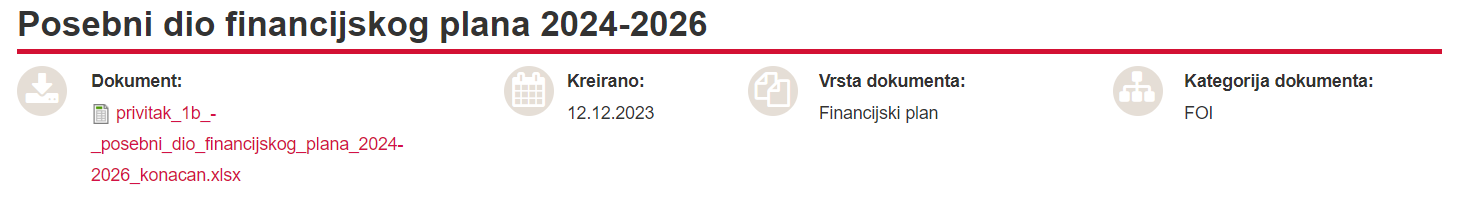

###### **Broj PDF-ova i ostalih tipova datoteka**

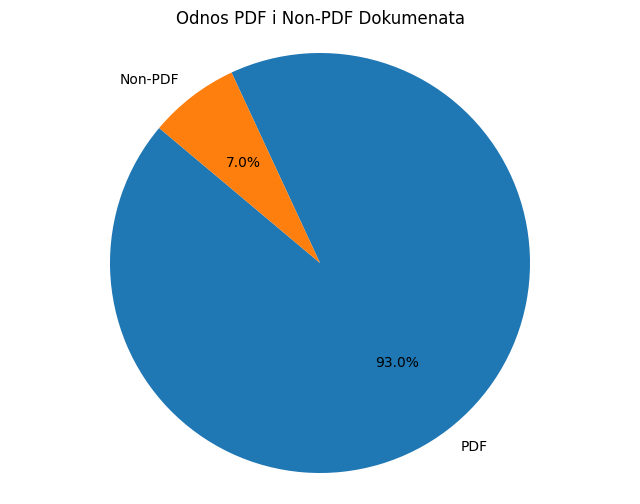

In [18]:
pdf_count = df['url'].notna().sum()
non_pdf_count = df['url'].isna().sum()

labels = ['PDF', 'Non-PDF']
sizes = [pdf_count, non_pdf_count]

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Odnos PDF i Non-PDF Dokumenata')
plt.show()

Kako nas zanimaju samo PDF dokumenti možemo izbaciti sve redove koji u stupcu `url` imaju `None`. Nakon izbacivanja ne-PDF dokumenata resetirat ćemo indeks i konvertirati vrijednosti u stupcu `datum` u `datetime` objekte.

In [19]:
df.dropna(subset = ['url'], inplace = True)
df.reset_index(drop = True, inplace = True)
df['datum'] = pd.to_datetime(df['datum'], format = '%d.%m.%Y') 

###### **Najčešće vrste i kategorije dokumenata**

Dokument ponekad spada u više vrsta/kategorija pa ih moramo razdvojiti prije analize.

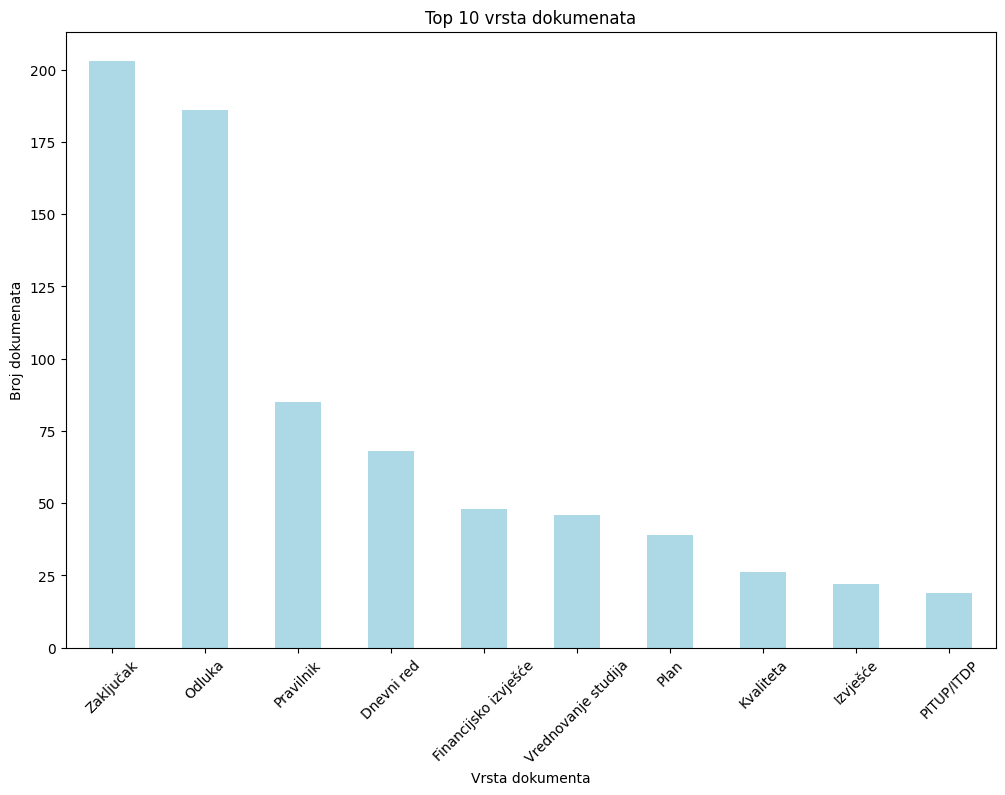

In [20]:
# Konvertiranje stupca 'kategorija_dokumenta' u listu kategorija
types_list = df['vrsta_dokumenta'].dropna().str.split(',').sum()
types_list = [type.strip() for type in types_list] 

# Pregled pojavljivanja kategorija
type_counts = pd.Series(types_list).value_counts()

# Uzimanje top 10 kategorija
top_10_types = type_counts.head(10)

# Bar chart
plt.figure(figsize=(12, 8))
top_10_types.plot(kind='bar', color='lightblue')
plt.title('Top 10 vrsta dokumenata')
plt.xlabel('Vrsta dokumenta')
plt.ylabel('Broj dokumenata')
plt.xticks(rotation=45)
plt.show()

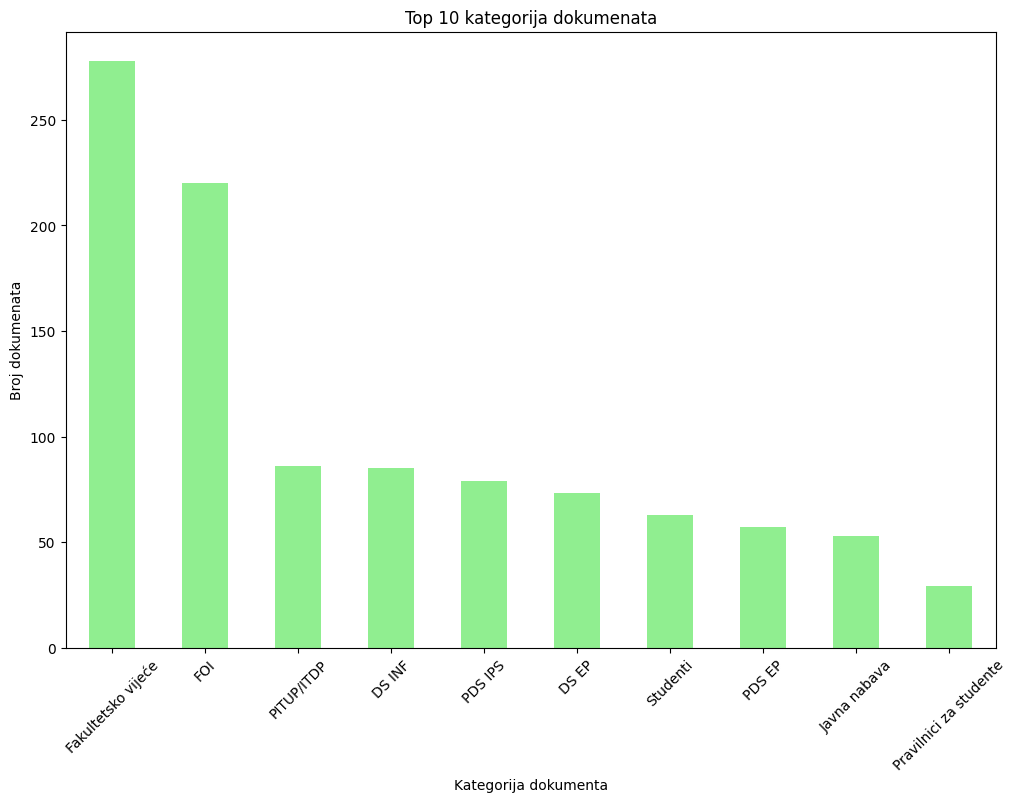

In [21]:
# Konvertiranje stupca 'kategorija_dokumenta' u listu kategorija
categories_list = df['kategorija_dokumenta'].dropna().str.split(',').sum()
categories_list = [category.strip() for category in categories_list]

# Pregled pojavljivanja kategorija
category_counts = pd.Series(categories_list).value_counts()

# Uzimanje top 10 kategorija
top_10_categories = category_counts.head(10)

# Bar chart
plt.figure(figsize=(12, 8))
top_10_categories.plot(kind='bar', color='lightgreen')
plt.title('Top 10 kategorija dokumenata')
plt.xlabel('Kategorija dokumenta')
plt.ylabel('Broj dokumenata')
plt.xticks(rotation=45)
plt.show()

###### **Broj dokumenata po godini**

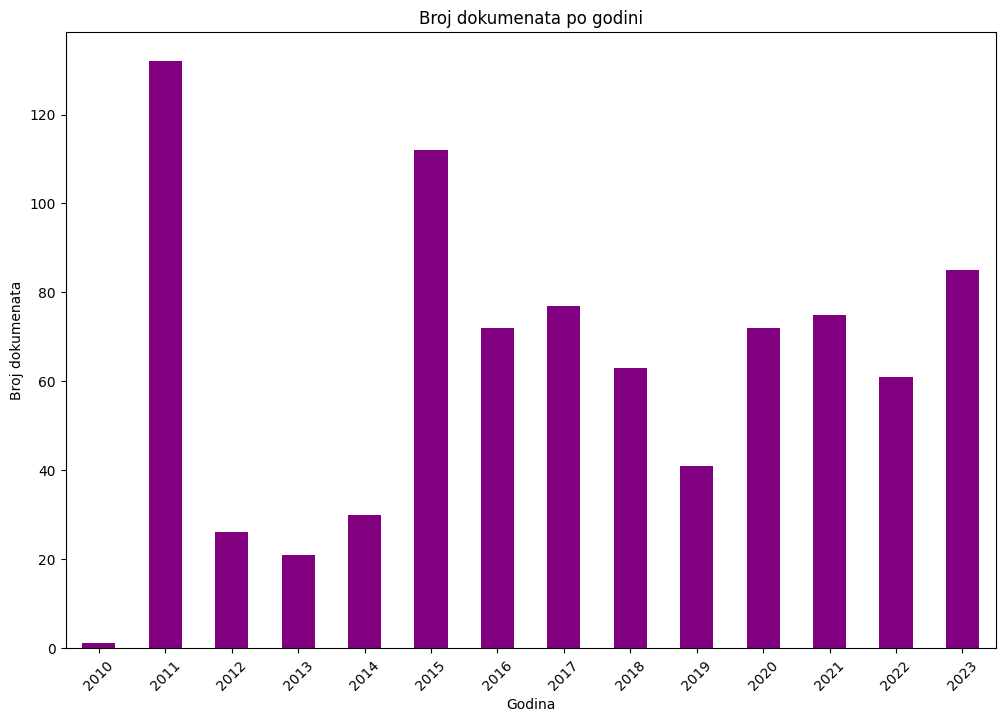

In [22]:
# Broj dokumenata po godini
documents_per_year = df['datum'].dt.year.value_counts().sort_index()

# Bar chart
plt.figure(figsize=(12, 8))
documents_per_year.plot(kind='bar', color='purple')
plt.title('Broj dokumenata po godini')
plt.xlabel('Godina')
plt.ylabel('Broj dokumenata')
plt.xticks(rotation=45)
plt.show()

Za daljnju upotrebu nam ne trebaju svi stupci pa ih možemo izbaciti

In [23]:
df.drop(['naziv_datoteke', 'vrsta_dokumenta', 'kategorija_dokumenta', 'metadata_link'], axis = 1, inplace = True) # izbacivanje nepotrebnih stupaca

In [24]:
df.shape

(868, 3)

In [25]:
df.head()

,url,datum,naslov_dokumenta
0,https://www.foi.unizg.hr/sites/default/files/o...,2023-12-18,Izmjenjena odluka POK-a 2023.
1,https://www.foi.unizg.hr/sites/default/files/o...,2023-12-12,Odluka o raspisivanju izvanrednih izbora Stude...
2,https://www.foi.unizg.hr/sites/default/files/f...,2023-12-07,Dnevni red Fakultetskog vijeća 07.12.2023.
3,https://www.foi.unizg.hr/sites/default/files/p...,2023-11-24,Politika privatnosti FOI-ja
4,https://www.foi.unizg.hr/sites/default/files/p...,2023-11-20,Popis gospodarskih subjekata s kojima se ne sm...


#### Ekstrakcija teksta iz dokumenata

Sljedeće tri funkcije su dizajnirane za izvlačenje teksta iz običnih i skeniranih PDF datoteka, koristeći razne biblioteke kao što su `fitz`, `pytesseract`, `PIL`, `io`, i `pdfminer`.

**Funkcije**

##### `is_scanned_pdf(file_path)`

Provjerava da li je PDF skenirani dokument.

- Koristi `extract_text` za pokušaj izvlačenja teksta.
- Ako nema teksta, zaključuje da je PDF skeniran.

##### `extract_text_from_scanned_pdf(file_path)`

Izvlači tekst iz skeniranog PDF-a.

- Otvora PDF s `fitz.open`.
- Za svaku stranicu:
  - Učitava stranicu i dobiva pixmap.
  - Pretvara pixmap u PIL sliku.
  - Koristi `pytesseract.image_to_string` za OCR.
  - Konkatenira tekst svake stranice.
- Zatvara dokument i vraća tekst.

##### `extract_text_from_pdf(file_path)`

Određuje metodu izvlačenja teksta na osnovu tipa PDF-a.

- Ako je PDF skeniran (provjereno s `is_scanned_pdf`), koristi `extract_text_from_scanned_pdf`.
- Inače, koristi `extract_text` za izvlačenje teksta.


In [26]:
def is_scanned_pdf(file_path):
    text = extract_text(file_path)
    return len(text.strip()) == 0

def extract_text_from_scanned_pdf(file_path):
    document = fitz.open(file_path)
    text = ""

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        pix = page.get_pixmap()
        image = Image.open(BytesIO(pix.tobytes()))
        text += pytesseract.image_to_string(image, lang = 'hrv')

    document.close()
    return text

def extract_text_from_pdf(file_path):
    if is_scanned_pdf(file_path):
        return extract_text_from_scanned_pdf(file_path)
    else:
        return extract_text(file_path)

#### Preuzimanje dokumenata i pohranjivanje tekstualnog sadržaja u `df`

Ovaj dio koda koristi se za obradu dokumenata i primjenjuje se paralelno na svaki redak DataFrame-a `df` koristeći `ThreadPoolExecutor`.

**Funkcija `process_document(row)`**

Ova funkcija obrađuje jedan redak DataFrame-a.

- Preuzima PDF s URL-a navedenog u retku i sprema ga u direktorij.
- Ako je preuzimanje uspješno, izvlači tekst iz PDF-a.
- Čisti tekst i vraća tekst zajedno s putanjom datoteke.
- Ako preuzimanje nije uspješno, vraća `None, None`.

**Primjena `process_document` Funkcije**

Korištenjem `ThreadPoolExecutor` s najviše 10 radnih niti:

- `with ThreadPoolExecutor(max_workers=10) as executor`: Stvara pool radnih niti za paralelno izvršavanje
- `df.apply(lambda row: process_document(row), axis=1, result_type='expand')`: Primjenjuje funkciju na svaki redak DataFrame-a
  - `lambda row: process_document(row)`: Anonimna funkcija za pozivanje `process_document`.
  - `axis=1`: Primjena funkcije na svaki redak
  - `result_type='expand'`: Osigurava pravilno raspoređivanje povratnih rezultata u nove stupce DataFrame-a

Rezultati se dodjeljuju novim stupcima `df[['tekstualni_sadrzaj', 'putanja_datoteke']]`.

In [43]:
def process_document(row):
    file_path = download_pdf(row['url'], './data/pdfs')
    if file_path:
        text = extract_text_from_pdf(file_path)
        return text.strip(), file_path
    return None, None

with ThreadPoolExecutor(max_workers=10) as executor:
    df[['tekstualni_sadrzaj', 'putanja_datoteke']] = df.apply(lambda row: process_document(row), axis=1, result_type='expand')

Success: ./data/pdfs/odluka_o_izmjeni_odluke_pok_2023_10_12_0.pdf
Success: ./data/pdfs/odluka-izvanredni_izbori_za_studentski_zbor-sijecanj_2024.pdf
Success: ./data/pdfs/fv_dnevni_red_2023-12-07_3._sjednica.pdf
Success: ./data/pdfs/politika-privatnosti-foi.pdf
Success: ./data/pdfs/popis_gs_u_sukobu_interesa_2023.pdf
Success: ./data/pdfs/fv_zakljucci_2023-11-16_2._sjednica.pdf
Success: ./data/pdfs/fv_dnevni_red_2023-11-16.pdf
Success: ./data/pdfs/odluka_studentski_pravobranitelj.pdf
Success: ./data/pdfs/01._zakljucci_13._sjednice_fv-final-uz_izmjene.pdf
Success: ./data/pdfs/odluka_izvanredni_ispitni_rokovi_2023_2024.pdf
Success: ./data/pdfs/odluka_upisni_kriteriji_za_prijediplomske_studije_2024_2025.pdf
Success: ./data/pdfs/zakljucci_1._sjednice_fv_16.11.2023.pdf
Success: ./data/pdfs/fv_dnevni_red_2023-10-19.pdf
Success: ./data/pdfs/odluka-podnosenje_zamolbi_za_ispis_s_fakulteta.pdf
Success: ./data/pdfs/odluka_o_imenovanju_povjerenika_za_zastitu_dostojanstva_radnika-1.pdf
Success: ./dat

#### Kreiranje baze podataka

Stvara se SQLite baza podataka s nazivom `docs.db` i u njoj se kreira tablica dokument.

In [9]:
engine = create_engine('sqlite:///docs.db')

metadata = MetaData()

# Definiranje tablice 'dokument'
dokument = Table('dokument', metadata,
                 Column('sifra_dokumenta', Integer, primary_key=True),
                 Column('url', String),
                 Column('datum', DateTime),
                 Column('naslov_dokumenta', String),
                 Column('tekstualni_sadrzaj', Text),
                 Column('putanja_datoteke', String))

# Kreiranje tablice
metadata.create_all(engine)

Zatim iteriramo po zapisima `df`-a, za svaki od njih se kreira odgovarajući *insert statement* koji se na kraju izvršava (zapis se pohranjuje u bazu podataka).

In [10]:
for index, row in df.iterrows():
    # Insert za pojedini zapis
    insert_stmt = insert(dokument).values(
        url = row['url'],
        datum = row['datum'],
        naslov_dokumenta = row['naslov_dokumenta'],
        tekstualni_sadrzaj = row['tekstualni_sadrzaj'],
        putanja_datoteke = row['putanja_datoteke']
    )

    # Izvršavanje insert-a
    with engine.connect() as conn:
        conn.execute(insert_stmt)
        conn.commit()

### REST servis

Svrha ovog REST servisa je pretraga ključnih riječi u naslovu/tekstu dokumenta, pregled dokumenata po datumu te izlistavanje svih dokumenata.

#### Potporne funkcije

##### Pregled dokumenata po datumu

Funkcija `list_docs_in_period` je dizajnirana da pregleda i izlista dokumente unutar određenog vremenskog razdoblja iz baze podataka.

**Parametri**
- `table`: Tablica baze podataka iz koje se preuzimaju dokumenti
- `e`: Engine objekt SQLAlchemy, koji upravlja vezom s bazom podataka
- `start_date`: Početni datum raspona (u formatu 'YYYY-MM-DD')
- `end_date`: Krajnji datum raspona (u formatu 'YYYY-MM-DD')

**Funkcionalnost**
1. **Priprema za pretragu**:
   
    Funkcija priprema listu imena stupaca iz tablice baze podataka, te pretvara stringove `start_date` i `end_date` u `datetime` objekte.

2. **Izgradnja SQL upita**:
   
    Kreira se SQL upit koji selektira sve redove iz tablice čiji su datumi unutar zadanog raspona.

3. **Izvršavanje upita i prikupljanje rezultata**:
   
    Otvora se veza s bazom podataka i izvršava pripremljeni SQL upit.
    Za svaki redak u rezultatu, stvara se rječnik s podacima koji se dodaje u listu.

**Povratna vrijednost**
    
Vraća listu rječnika gdje svaki rječnik sadrži podatke jednog dokumenta unutar zadanog datumskog raspona.

Funkcija `valid_date` provjerava je li dani string valjan datum u formatu 'YYYY-MM-DD'.

**Parametri**
- `date_str`: String koji predstavlja datum koji se provjerava

**Funkcionalnost**
1. **Provjera valjanosti datuma**:
   
    Pokušava pretvoriti `date_str` u `datetime` objekt koristeći format 'YYYY-MM-DD'.
    Ako je konverzija uspješna, datum je valjan i funkcija vraća `True`.
    Ukoliko konverzija ne uspije i izazove `ValueError`, to znači da je format datuma neispravan, i funkcija vraća `False`.

**Povratna vrijednost**

Vraća `True` ako je datum valjan, ili `False` ako nije.

In [11]:
# Pregled prema datumu
def list_docs_in_period(table, e, start_date, end_date):
    rows = []
    column_names = [column.name for column in table.columns]

    # Pretvaranje stringova u datetime objekte
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    select_stmt = select(table).where(table.c.datum.between(start, end))
    
    with e.connect() as conn:
        result = conn.execute(select_stmt)
        for row in result:
            row_dict = {column: getattr(row, column) for column in column_names}
            rows.append(row_dict)

    return rows

# Validacija datuma
def valid_date(date_str):
    try:
        datetime.strptime(date_str, "%Y-%m-%d")
        return True
    except ValueError:
        return False

##### Izlistavanje svih dokumenata

Funkcija `list_all_docs` izlistava sve dokumente iz zadane tablice u bazi podataka.

**Parametri**
- `table`: Tablica baze podataka iz koje se izlistavaju dokumentiu
- `e`: SQLAlchemy Engine objekt, koji upravlja vezom s bazom podataka

**Funkcionalnost**
1. **Priprema za izlistavanje**:

    Imena stupaca u tablici se spremaju u listu kako bi se podaci točno mapirali

3. **Izgradnja SQL upita**:

    Kreira se SQL upit koji selektira sve zapise iz tablice

5. **Izvršavanje upita i prikupljanje podataka**:

    Otvora se vezu s bazom podataka i izvršava pripremljeni SQL upit.
    Za svaki zapis iz tablice, funkcija kreira rječnik koji sadrži sve podatke tog redaka i dodaje ga u listu `rows`.

**Povratna vrijednost**
    
Vraća listu rječnika, gdje svaki rječnik predstavlja jedan dokument iz tablice.

In [12]:
# Izlistavanje svih dokumenata
def list_all_docs(table, e):
    rows = []
    column_names = [column.name for column in table.columns]

    select_stmt = select(table)
    with e.connect() as conn:
        result = conn.execute(select_stmt)
        for row in result:
            # Izgradnja rječnika za svaki redak
            row_dict = {column: getattr(row, column) for column in column_names}
            rows.append(row_dict)

    return rows

##### Pretprocesiranje teksta i pretraga

Funkcija `preprocess` je namijenjena za procesiranje i čišćenje teksta.

**Parametri**
- `text`: String

**Funkcionalnost**
1. **Uklanjanje nepotrebnih znakova**:

    Funkcija primjenjuje regularni izraz za uklanjanje svih znakova koji nisu slova ili brojevi (`\W`), zamjenjujući ih razmakom. Ovaj korak uklanja
    interpunkcijske i specijalne znakove iz teksta.

3. **Normalizacija teksta**:

    Nadalje, tekst se pretvara u mala slova koristeći metodu `lower()`. Ovo osigurava da veličina slova ne utječe na kasniju analizu teksta.

**Povratna vrijednost**

Pretprocesirani tekst bez interpunkcijskih i specijalnih znakova.

Funkcija `load_and_preprocess_data` zadužena je za učitavanje i pretprocesiranje podataka potrebnih za daljnje analize. Funkcija integrira nekoliko ključnih koraka u jednom procesu, uključujući učitavanje podataka, njihovo pretprocesiranje, i vektorizaciju.

**Funkcionalnost**
1. **Učitavanje podataka iz baze**:
   
    Podaci se učitavaju iz baze podataka koristeći funkciju `list_all_docs`, koja vraća sve dokumente iz tablice `dokument`. Rezultat se zatim
    pretvara u pandas DataFrame.

3. **Pretprocesiranje teksta**:
   
    Primjenjuje funkciju `preprocess` na stupce `naslov_dokumenta` i `tekstualni_sadrzaj` DataFrame-a kako bi se tekst standardizirao.
    Rezultat se pohranjuje u nove stupce `processed_naslov` i `processed_tekst`.

5. **Vektorizacija teksta**:
   
    Koristi `TfidfVectorizer` za pretvaranje naslova i tekstova dokumenata u TF-IDF vektore. Ovaj korak je ključan za pretvaranje
    teksta u numerički oblik koji se može koristiti u strojnom učenju i drugim analitičkim alatima.

**Povratna vrijednost**
    
Vraća pandas DataFrame s pretprocesiranim podacima, dva objekta `TfidfVectorizer` (za naslove i tekstove), te TF-IDF matrice za naslove i tekstove.

Funkcija `multi_word_search_or` dizajnirana je za pretragu dokumenata koji sadrže bilo koju od zadanih riječi. Ova funkcija koristi vektorski prikaz dokumenata i vektorizer za identifikaciju dokumenata koji odgovaraju kriterijima pretrage.

**Parametri**
- `document_matrix`: Matrica dokumenata, gdje je svaki redak vektorski prikaz jednog dokumenta
- `vectorizer`: Objekt `TfidfVectorizer` koji se koristio za vektorizaciju dokumenata
- `words`: Niz riječi odvojenih razmakom koje se traže u dokumentima

**Funkcionalnost**
1. **Dobivanje indeksa riječi**:
   
    Funkcija prvo pretvara svaku riječ iz niza `words` u njezin odgovarajući indeks u vokabularu koji je kreiran pomoću `TfidfVectorizer`.

2. **Pretraga dokumenta**:
   
    Zatim prolazi kroz svaki redak u `document_matrix` (koji predstavlja jedan dokument) i provjerava sadrži li bilo koji od indeksa (riječi)
    s ne-nul vrijednostima.

4. **Identifikacija relevantnih dokumenata**:
   
    Ako redak (dokument) sadrži bilo koju od traženih riječi, indeks tog reda se dodaje u listu `found_docs`.

**Povratna vrijednost**
    
Vraća listu indeksa dokumenata koji zadovoljavaju uvjete pretrage.

In [13]:
# Funkcija za pretprocesiranje teksta
def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    return text

def load_and_preprocess_data():
    # Učitavanje podataka iz baze
    documents = list_all_docs(dokument, engine)
    df = pd.DataFrame(documents)

    # Pretprocesiranje
    df['processed_naslov'] = df['naslov_dokumenta'].apply(preprocess)
    df['processed_tekst'] = df['tekstualni_sadrzaj'].apply(preprocess)

    # Vektorizacija
    vectorizer_naslovi = TfidfVectorizer()
    vectorizer_tekstovi = TfidfVectorizer()
    naslovi_tfidf = vectorizer_naslovi.fit_transform(df['processed_naslov'])
    tekstovi_tfidf = vectorizer_tekstovi.fit_transform(df['processed_tekst'])

    return df, vectorizer_naslovi, vectorizer_tekstovi, naslovi_tfidf, tekstovi_tfidf

def multi_word_search_or(document_matrix, vectorizer, words):
    indices = [vectorizer.vocabulary_.get(word.lower()) for word in words.split()]
    found_docs = []
    for index, row in enumerate(document_matrix.toarray()):
        if any(row[i] > 0 for i in indices if i is not None):
            found_docs.append(index)
    return found_docs

##### REST API

Ovaj REST servis implementiran je korištenjem Flask frameworka i nudi širok spektar funkcionalnosti za pristup i upravljanje dokumentima Fakulteta organizacije i informatike (FOI). Osim osnovnih funkcionalnosti poput dodavanja, ažuriranja i brisanja dokumenata, servis pruža i specifične funkcionalnosti pretrage i pregleda dokumenata:

a) Pretraživanje ključnih riječi u tekstu i b) Pretraživanje ključnih riječi u naslovu
- **Putanja**: `/search`
- **Metoda**: `GET`
- Funkcija `search_documents` omogućava korisnicima da pretražuju dokumente koristeći ključne riječi. Moguće je specificirati da li pretraga treba biti izvedena unutar teksta dokumenta ili unutar naslova. Učitava se i pretprocesira skup podataka, nakon čega se izvodi pretraga pomoću funkcije `multi_word_search_or`.

c) Pregled prema datumu
- **Putanja**: `/documents/<date_from>/<date_to>`
- **Metoda**: `GET`
- Funkcija `get_documents_date_range` omogućava korisnicima da pregledaju dokumente unutar određenog vremenskog razdoblja. Korisnici specificiraju početni (`date_from`) i krajnji datum (`date_to`) za pretragu. Prije izvršavanja pretrage izvršava se validacija datuma.

d) Izlistavanje svih dokumenata
- **Putanja**: `/documents`
- **Metoda**: `GET`
- Funkcija `get_documents` omogućava korisnicima da dobiju listu svih dostupnih dokumenata u bazi.

Osim navedenih funkcionalnosti, servis također podržava dodavanje, ažuriranje i brisanje dokumenata, kao i dohvaćanje pojedinačnih dokumenata prema njihovom identifikatoru (šifra dokumenta).

In [14]:
app = Flask(__name__)

@app.route('/')
def start():
    return '<h1>Flask REST API za FOI dokumente</h1>'

# a) pretraživanja ključnih riječi u tekstu (npr. boolean search) &
# b) pretraživanje ključnih riječi u naslovu
@app.route('/search', methods=['GET'])
def search_documents():
    query = request.args.get('query')
    search_in = request.args.get('in')

    if not query or not search_in:
        return jsonify({"error": "Query and search field are required"}), 400

    # Učitavanje i preprocesiranje podataka
    df, vectorizer_naslovi, vectorizer_tekstovi, naslovi_tfidf, tekstovi_tfidf = load_and_preprocess_data()

    matrix = naslovi_tfidf if search_in == 'naslov' else tekstovi_tfidf
    vectorizer = vectorizer_naslovi if search_in == 'naslov' else vectorizer_tekstovi

    found_indices = multi_word_search_or(matrix, vectorizer, query)

    if not found_indices:
        return jsonify({"message": "No documents found"}), 404

    columns_to_return = ['sifra_dokumenta', 'url', 'datum', 'naslov_dokumenta', 'tekstualni_sadrzaj', 'putanja_datoteke']
    found_documents = df.iloc[found_indices][columns_to_return]
    return jsonify(found_documents.to_dict(orient='records'))

# c) pregled prema datumu (npr. dokumenti od DATUM do DATUM)
@app.route('/documents/<date_from>/<date_to>', methods=['GET'])
def get_documents_date_range(date_from, date_to):
    if not valid_date(date_from) or not valid_date(date_to):
        return jsonify({"error": "Invalid date format, should be YYYY-MM-DD"}), 400

    documents = list_docs_in_period(dokument, engine, date_from, date_to)
    return jsonify(documents)
    
# d) izlistavanje svih dokumenata
@app.route('/documents', methods=['GET'])
def get_documents():
    documents = list_all_docs(dokument, engine)
    return jsonify(documents)

@app.route('/document/<int:doc_id>', methods=['GET'])
def get_document(doc_id):
    select_stmt = select(dokument).where(dokument.c.sifra_dokumenta == doc_id)
    with engine.connect() as conn:
        result = conn.execute(select_stmt).fetchone()
        if result:
            document_dict = {column.name: getattr(result, column.name) for column in dokument.columns}
            return jsonify(document_dict)
        else:
            return jsonify({"error": "Document not found"}), 404

@app.route('/documents', methods=['POST'])
def add_document():
    data = request.json
    # Pretvaranje datuma iz stringa u datetime objekt
    if 'datum' in data:
        try:
            data['datum'] = datetime.fromisoformat(data['datum'])
        except ValueError:
            return jsonify({"error": "Invalid date format"}), 400

    insert_stmt = insert(dokument).values(data)
    with engine.connect() as conn:
        conn.execute(insert_stmt)
        conn.commit()
    return jsonify({"message": "Document added successfully"}), 201

@app.route('/documents/<int:doc_id>', methods=['PUT'])
def update_document(doc_id):
    data = request.json

    # Convert 'datum' from string to datetime object
    if 'datum' in data:
        try:
            data['datum'] = datetime.fromisoformat(data['datum'])
        except ValueError:
            return jsonify({"error": "Invalid date format"}), 400

    update_stmt = update(dokument).where(dokument.c.sifra_dokumenta == doc_id).values(data)
    with engine.connect() as conn:
        result = conn.execute(update_stmt)
        conn.commit()
        if result.rowcount:
            return jsonify({"message": "Document updated successfully"})
        else:
            return jsonify({"error": "Document not found"}), 404

@app.route('/documents/<int:doc_id>', methods=['DELETE'])
def delete_document(doc_id):
    delete_stmt = delete(dokument).where(dokument.c.sifra_dokumenta == doc_id)
    with engine.connect() as conn:
        result = conn.execute(delete_stmt)
        conn.commit()
        if result.rowcount:
            return jsonify({"message": "Document deleted successfully"})
        else:
            return jsonify({"error": "Document not found"}), 404
    
# Pokretanje aplikacije
def run_app():
    app.run(port=5000, use_reloader=False)
    
flask_thread = threading.Thread(target=run_app)
flask_thread.start()
# gasenje servera - Kernel -> Restart kernel

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


## Prikaz rada aplikacije

### Izlistavanje svih dokumenata

In [20]:
!curl http://127.0.0.1:5000/documents

127.0.0.1 - - [01/Jan/2024 18:23:54] "GET /documents HTTP/1.1" 200 -


[{"datum":"Mon, 18 Dec 2023 00:00:00 GMT","naslov_dokumenta":"Izmjenjena odluka POK-a 2023.","putanja_datoteke":"./data/pdfs/odluka_o_izmjeni_odluke_pok_2023_10_12_0.pdf","sifra_dokumenta":1,"tekstualni_sadrzaj":"KLASA: 602-04/23-06/1 \nURBROJ: 2186-62-06-23-76 \nVara\u017edin, 19. listopada 2023. \n\nNa temelju \u010dlanka 53. Statuta Sveu\u010dili\u0161ta u Zagrebu Fakulteta organizacije i informatike (dalje u \ntekstu: Fakultet) i \u010dlanka 8. i 9. Pravilnika o sustavu osiguravanja kvalitete Sveu\u010dili\u0161ta u Zagrebu \nFakulteta organizacije i informatike (u daljnjem tekstu: Pravilnik), Fakultetsko vije\u0107e Fakulteta, \nna sjednici odr\u017eanoj 19. listopada 2023. godine, donosi \n\nO D L U K U  \n\nI. \nProf. dr. sc. Renata Mekovec imenuje se za predsjednicu Povjerenstva za osiguravanje kvalitete \nSveu\u010dili\u0161ta  u  Zagrebu  Fakulteta  organizacije  i  informatike  (u  daljnjem  tekstu:  Povjerenstvo) \numjesto dosada\u0161njeg predsjednika prof. dr. sc. Zlatka 

### Pretraga po kljucnim rijecima u naslovu

In [25]:
!curl 'http://127.0.0.1:5000/search?query=politika+privatnosti&in=naslov'

127.0.0.1 - - [02/Jan/2024 15:33:02] "GET /search?query=odluka&in=naslov HTTP/1.1" 200 -


[{"datum":"Mon, 18 Dec 2023 00:00:00 GMT","naslov_dokumenta":"Izmjenjena odluka POK-a 2023.","putanja_datoteke":"./data/pdfs/odluka_o_izmjeni_odluke_pok_2023_10_12_0.pdf","sifra_dokumenta":1,"tekstualni_sadrzaj":"KLASA: 602-04/23-06/1 \nURBROJ: 2186-62-06-23-76 \nVara\u017edin, 19. listopada 2023. \n\nNa temelju \u010dlanka 53. Statuta Sveu\u010dili\u0161ta u Zagrebu Fakulteta organizacije i informatike (dalje u \ntekstu: Fakultet) i \u010dlanka 8. i 9. Pravilnika o sustavu osiguravanja kvalitete Sveu\u010dili\u0161ta u Zagrebu \nFakulteta organizacije i informatike (u daljnjem tekstu: Pravilnik), Fakultetsko vije\u0107e Fakulteta, \nna sjednici odr\u017eanoj 19. listopada 2023. godine, donosi \n\nO D L U K U  \n\nI. \nProf. dr. sc. Renata Mekovec imenuje se za predsjednicu Povjerenstva za osiguravanje kvalitete \nSveu\u010dili\u0161ta  u  Zagrebu  Fakulteta  organizacije  i  informatike  (u  daljnjem  tekstu:  Povjerenstvo) \numjesto dosada\u0161njeg predsjednika prof. dr. sc. Zlatka 

### Pretraga po kljucnim rijecima u tekstu

In [26]:
!curl 'http://127.0.0.1:5000/search?query=popis&in=tekst'

127.0.0.1 - - [02/Jan/2024 15:33:09] "GET /search?query=popis&in=tekst HTTP/1.1" 200 -


[{"datum":"Mon, 20 Nov 2023 00:00:00 GMT","naslov_dokumenta":"Popis gospodarskih subjekata s kojima se ne smije sklapati ugovor o javnoj nabavi","putanja_datoteke":"./data/pdfs/popis_gs_u_sukobu_interesa_2023.pdf","sifra_dokumenta":5,"tekstualni_sadrzaj":"foj s=> =\n\nKLASA: 303.02/23.02/2\n(URBROJ: 2186-62.01.23-135\nVara\u017edin, 17. studenog 2023,\n\nTemeljem \u010dlanka 80. st 2. to\u010d. 1. Zakona o javnoj nabavi (Narodne novine broj 120/2016, 11412022),\nFakultet organizacije i informatike Vara\u017edin, Pavinska 2, OB: 02024882310 objavjuje.\n\nPOPIS GOSPODARSKIH SUBJEKATA S KOJIMA NE SMIJE SKLAPATI\n(UGOVORE O JAVNOJ NABAVI\n\nU smislu \u010danka 76. Zakona o javnoj nabavi (Narodne nov/ne br 20/2016, 1142022) i Ode Fakueta\nomanizadje i nformatke Vara\u017edin od dana 20.11.2018 godine, Klasa: 305.02/16-022, Uo: 21862.\n0810179, sob interesa postoj sa sjede\u0107im gospodarskim subekima\n\nTomi 00, E: Kvatemika 15, Vara\u017edin, OIB: 6963033942\n\nQOPANALITIKA 600, Dravska u

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Pretraga po datumu

In [27]:
# Svi dokumenti iz prosinca 2023.
!curl http://127.0.0.1:5000/documents/2023-12-01/2024-01-01

127.0.0.1 - - [02/Jan/2024 15:33:11] "GET /documents/2023-12-01/2024-01-01 HTTP/1.1" 200 -


[{"datum":"Mon, 18 Dec 2023 00:00:00 GMT","naslov_dokumenta":"Izmjenjena odluka POK-a 2023.","putanja_datoteke":"./data/pdfs/odluka_o_izmjeni_odluke_pok_2023_10_12_0.pdf","sifra_dokumenta":1,"tekstualni_sadrzaj":"KLASA: 602-04/23-06/1 \nURBROJ: 2186-62-06-23-76 \nVara\u017edin, 19. listopada 2023. \n\nNa temelju \u010dlanka 53. Statuta Sveu\u010dili\u0161ta u Zagrebu Fakulteta organizacije i informatike (dalje u \ntekstu: Fakultet) i \u010dlanka 8. i 9. Pravilnika o sustavu osiguravanja kvalitete Sveu\u010dili\u0161ta u Zagrebu \nFakulteta organizacije i informatike (u daljnjem tekstu: Pravilnik), Fakultetsko vije\u0107e Fakulteta, \nna sjednici odr\u017eanoj 19. listopada 2023. godine, donosi \n\nO D L U K U  \n\nI. \nProf. dr. sc. Renata Mekovec imenuje se za predsjednicu Povjerenstva za osiguravanje kvalitete \nSveu\u010dili\u0161ta  u  Zagrebu  Fakulteta  organizacije  i  informatike  (u  daljnjem  tekstu:  Povjerenstvo) \numjesto dosada\u0161njeg predsjednika prof. dr. sc. Zlatka 

127.0.0.1 - - [02/Jan/2024 15:33:47] "GET /documents/2023-12-01/2024-01-01 HTTP/1.1" 200 -


### Dohvaćanje dokumenta po šifri dokumenta

In [17]:
# GET document
!curl http://127.0.0.1:5000/document/5

127.0.0.1 - - [02/Jan/2024 15:32:02] "GET /document/5 HTTP/1.1" 200 -


{"datum":"Mon, 20 Nov 2023 00:00:00 GMT","naslov_dokumenta":"Popis gospodarskih subjekata s kojima se ne smije sklapati ugovor o javnoj nabavi","putanja_datoteke":"./data/pdfs/popis_gs_u_sukobu_interesa_2023.pdf","sifra_dokumenta":5,"tekstualni_sadrzaj":"foj s=> =\n\nKLASA: 303.02/23.02/2\n(URBROJ: 2186-62.01.23-135\nVara\u017edin, 17. studenog 2023,\n\nTemeljem \u010dlanka 80. st 2. to\u010d. 1. Zakona o javnoj nabavi (Narodne novine broj 120/2016, 11412022),\nFakultet organizacije i informatike Vara\u017edin, Pavinska 2, OB: 02024882310 objavjuje.\n\nPOPIS GOSPODARSKIH SUBJEKATA S KOJIMA NE SMIJE SKLAPATI\n(UGOVORE O JAVNOJ NABAVI\n\nU smislu \u010danka 76. Zakona o javnoj nabavi (Narodne nov/ne br 20/2016, 1142022) i Ode Fakueta\nomanizadje i nformatke Vara\u017edin od dana 20.11.2018 godine, Klasa: 305.02/16-022, Uo: 21862.\n0810179, sob interesa postoj sa sjede\u0107im gospodarskim subekima\n\nTomi 00, E: Kvatemika 15, Vara\u017edin, OIB: 6963033942\n\nQOPANALITIKA 600, Dravska ui

### Dodavanje novog dokumenta

In [18]:
# POST
!curl -X POST http://127.0.0.1:5000/documents \
-H "Content-Type: application/json" \
-d '{"url": "http://example.com/document.pdf", "datum": "2023-12-28T00:00:00", "naslov_dokumenta": "Primjer dokumenta", "tekstualni_sadrzaj": "Ovo je sadržaj primjera dokumenta.", "putanja_datoteke": "/putanja/do/dokumenta.pdf"}'

127.0.0.1 - - [02/Jan/2024 15:32:07] "POST /documents HTTP/1.1" 201 -


{"message":"Document added successfully"}


In [21]:
# dohvaćanje dodanog dokumenta
!curl http://127.0.0.1:5000/document/869

127.0.0.1 - - [02/Jan/2024 15:32:21] "GET /document/869 HTTP/1.1" 200 -


{"datum":"Thu, 28 Dec 2023 00:00:00 GMT","naslov_dokumenta":"Primjer dokumenta","putanja_datoteke":"/putanja/do/dokumenta.pdf","sifra_dokumenta":869,"tekstualni_sadrzaj":"Ovo je sadr\u017eaj primjera dokumenta.","url":"http://example.com/document.pdf"}


### Ažuriranje dokumenta

In [22]:
# PUT
!curl -X PUT http://127.0.0.1:5000/documents/869 \
-H "Content-Type: application/json" \
-d '{"url": "http://newexample.com/document.pdf", "datum": "2023-12-28T00:00:00", "naslov_dokumenta": "Updated Document Title", "tekstualni_sadrzaj": "Updated content of the document.", "putanja_datoteke": "/new/path/to/document.pdf"}'

127.0.0.1 - - [02/Jan/2024 15:32:31] "PUT /documents/869 HTTP/1.1" 200 -


{"message":"Document updated successfully"}


In [23]:
# dohvaćanje ažuriranog dokumenta
!curl http://127.0.0.1:5000/document/869

127.0.0.1 - - [02/Jan/2024 15:32:39] "GET /document/869 HTTP/1.1" 200 -


{"datum":"Thu, 28 Dec 2023 00:00:00 GMT","naslov_dokumenta":"Updated Document Title","putanja_datoteke":"/new/path/to/document.pdf","sifra_dokumenta":869,"tekstualni_sadrzaj":"Updated content of the document.","url":"http://newexample.com/document.pdf"}


### Brisanje dokumenta

In [24]:
!curl -X DELETE http://127.0.0.1:5000/documents/869

127.0.0.1 - - [02/Jan/2024 15:32:49] "DELETE /documents/869 HTTP/1.1" 200 -


{"message":"Document deleted successfully"}


## Kritički osvrt

### Praktična izvedivost

1. **Skalabilnost**: Dok Flask nudi jednostavnost i fleksibilnost, potrebno je razmotriti njegovu skalabilnost, posebno ako se očekuje povećanje broja korisnika i zahtjeva. U tom slučaju, može biti potrebno razmisliti o korištenju asinkronih funkcija ili prelasku na robustniji web framework.

2. **Osiguranje performansi**: Ovisno o veličini i kompleksnosti baze podataka, učitavanje i pretprocesiranje podataka za svaku pretragu mogu utjecati na performanse. Optimizacija upita i korištenje *caching* mehanizama može pomoći u smanjenju vremena odziva.

### Primjena

1. **Akademska i istraživačka zajednica**: Aplikacija je korisna za studente, istraživače, nastavnike i djelatnika FOI-a, omogućujući im brz pristup relevantnim dokumentima. 

2. **Digitalna arhiviranja**: Aplikacija može poslužiti kao model za digitalno arhiviranje i upravljanje dokumentacijom u bibliotekama, s mogućnošću prilagodbe za različite vrste arhiva i knjižničnih kolekcija.

3. **Ekspanzija funkcionalnosti**: Postoje mogućnosti za daljnje proširenje funkcionalnosti, poput integracije s drugim digitalnim resursima, razvoja korisničkih sučelja za lakšu navigaciju, ili implementacije dodatnih alata za obradu i analizu teksta.

## Zaključak

### // TODO
- ~~boolean search~~
- scraping optimization (maybe)
- Documentation
- ~~README.md~~
- Literatura

# Literatura

[1] W. McKinney, Python for Data Analysis: Data Wrangling with Pandas, NumPy, and Jupyter, 3rd ed. Sebastopol, CA: O'Reilly Media, Incorporated, 2022. ISBN: 978-1098104030. Dostupno na: https://wesmckinney.com/book/